# GPU

CMBLensing uses [CUDA.jl](https://github.com/JuliaGPU/CUDA.jl) for GPU functionality. 

To use CUDA.jl, you'll need an Nvidia GPU and a recent version of the CUDA libraries. 

*NERSC-specific instructions:*
On NERSC, just load the modules `cudnn/7.6.5` and `cuda/10.2.89` (other versions may work but those have been tested) and add `export JULIA_CUDA_USE_BINARYBUILDER=false` to your bashrc. 

See also [install instructions](https://juliagpu.gitlab.io/CUDA.jl/installation/overview/) for more info. 

## CUDA basics

We'll need these packages:

In [77]:
using CUDA, Adapt, CMBLensing, Random, PyPlot

To check everything loaded correctly:

In [3]:
CUDA.device()

CuDevice(0): GeForce GTX 1080 Ti

In [4]:
CUDA.functional()

true

CUDA.jl provides an array type called `CuArray` which is an array that resides on GPU. You can convert `Array`s to `CuArray`s via the `adapt` function:

In [5]:
x_cpu = rand(128,128)
x_gpu = adapt(CuArray, x_cpu)

128×128 CuArray{Float64,2}:
 0.888712    0.824356   0.214376   …  0.755596    0.0433143  0.401218
 0.860261    0.363934   0.758443      0.463215    0.438527   0.188045
 0.486457    0.676236   0.265082      0.596669    0.633011   0.21782
 0.922882    0.309495   0.372102      0.414542    0.851956   0.0997972
 0.453549    0.502549   0.428112      0.238626    0.755366   0.611219
 0.632588    0.812622   0.438778   …  0.229711    0.121807   0.358687
 0.469266    0.0297919  0.0228982     0.287558    0.972336   0.338394
 0.241879    0.375037   0.822643      0.458313    0.110923   0.0838822
 0.147324    0.757712   0.416574      0.0792948   0.135277   0.95459
 0.464468    0.515546   0.119434      0.392862    0.4709     0.334125
 0.0577308   0.87099    0.286543   …  0.899621    0.349562   0.430823
 0.460388    0.100913   0.2076        0.977196    0.225323   0.435314
 0.38272     0.244247   0.468403      0.0425952   0.0149343  0.646776
 ⋮                                 ⋱  ⋮                      


Any operations you now to do `x_gpu` are done on GPU and are super fast (although benchmarking can be [subtle](https://juliagpu.gitlab.io/CUDA.jl/development/profiling/)):

In [6]:
2 * x_gpu + x_gpu # happened on GPU

128×128 CuArray{Float64,2}:
 2.66614    2.47307    0.643129   2.05436   …  2.26679    0.129943   1.20365
 2.58078    1.0918     2.27533    0.812263     1.38964    1.31558    0.564134
 1.45937    2.02871    0.795247   2.10365      1.79001    1.89903    0.653459
 2.76865    0.928484   1.11631    2.65855      1.24363    2.55587    0.299392
 1.36065    1.50765    1.28434    0.731794     0.715879   2.2661     1.83366
 1.89776    2.43787    1.31634    1.06633   …  0.689134   0.365422   1.07606
 1.4078     0.0893757  0.0686946  2.45819      0.862674   2.91701    1.01518
 0.725638   1.12511    2.46793    2.58974      1.37494    0.332768   0.251647
 0.441972   2.27313    1.24972    1.47896      0.237884   0.405831   2.86377
 1.3934     1.54664    0.358303   1.21855      1.17859    1.4127     1.00237
 0.173192   2.61297    0.859628   2.33799   …  2.69886    1.04869    1.29247
 1.38117    0.302738   0.622801   0.252359     2.93159    0.675968   1.30594
 1.14816    0.732742   1.40521    2.86669   

Note we also have three shorthands for using `adapt`: 

* `cu(x)  = adapt(CuArray{Float32}, x)`
* `gpu(x) = adapt(CuArray, x)`
* `cpu(x) = adapt(Array, x)`

## CMBLensing GPU basics

CMBLensing fields can be put on GPU in exactly the same way.

In [7]:
f_cpu = FlatMap(rand(128,128))
f_gpu = cu(f_cpu)

16384-element 128×128-pixel 1.0′-resolution FlatMap{CuArray{Float32,2},ProjLambert{Float32}}:
 0.69471073
 0.18825004
 0.5484901
 0.43423572
 0.8342005
 0.93333364
 0.2082479
 0.040642317
 0.022252865
 0.6725115
 0.86915433
 0.7677295
 0.67226666
 ⋮
 0.17374569
 0.9538183
 0.725677
 0.45780742
 0.15167615
 0.47352484
 0.21508026
 0.99338794
 0.8053882
 0.23090039
 0.32536042
 0.082422785

Everything you can do to a CPU Field object you can do to a GPU one. 

In [8]:
f_gpu' * (2 * Fourier(f_gpu))

11048.801f0

`cu(x)` works recursively through most objects, for example through NamedTuples:

In [9]:
(x=f_cpu, y=f_cpu) |> typeof

NamedTuple{(:x, :y),Tuple{FlatMap{Array{Float64,2},ProjLambert{Float64}},FlatMap{Array{Float64,2},ProjLambert{Float64}}}}

In [10]:
cu((x=f_cpu, y=f_cpu)) |> typeof

NamedTuple{(:x, :y),Tuple{FlatMap{CuArray{Float32,2},ProjLambert{Float32}},FlatMap{CuArray{Float32,2},ProjLambert{Float32}}}}

You can move an entire `DataSet` to GPU too with `cu(ds)`, which recursively moves all the fields and operators inside this object to GPU:

In [11]:
@unpack ds, ϕ = load_sim(Nside=256, θpix=3, pol=:P);

In [12]:
ds.d |> typeof

FlatEBFourier{Array{Complex{Float32},3},ProjLambert{Float32}}

In [13]:
cu(ds).d |> typeof

FlatEBFourier{CuArray{Complex{Float32},3},ProjLambert{Float32}}

You can also generate the `DataSet` directly on GPU, which is often much faster:

In [14]:
@unpack ds, ϕ = load_sim(Nside=256, θpix=3, pol=:P, storage=CuArray);

Once you have the `DataSet` object on GPU, all the normal high-level operations work on it, e.g.:

In [33]:
fJ,ϕJ = MAP_joint(ds, nsteps=10, progress=true);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:03
  step:  10
  χ²:    131546.67
  Ncg:   3


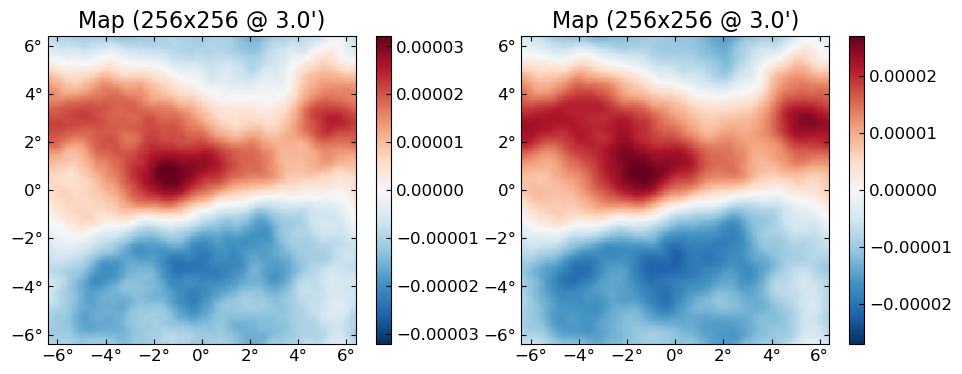

In [34]:
plot([ϕ ϕJ])

## Batching

Just moving a `DataSet` to GPU will give you factors of about 2 - 10 speeds over CPU for `Nside` of 128 - 1024. You can go even faster by "batching," which means doing the same operations to multiple fields at once, i.e. in "batches". The trick is that by putting multiple fields together into a single array, you reduce the number of GPU kernel calls needed as compared to simply looping over each field. This saves on the overhead of launching GPU kernels, and also often leads to accessing memory in a more efficient order. 

Suppose you had 10 fields on GPU that you want to lense:

In [68]:
fs = [simulate(ds.Cf) for i=1:10]
ϕs = [simulate(ds.Cϕ) for i=1:10];

You could do the following, and it might still be a little faster than doing it sequentially:

In [69]:
f̃s = [LenseFlow(ϕ)*f for (f,ϕ) in zip(fs,ϕs)];

But the _really_ fast way to do it is pack those 10 fields into a batched field (note the indication these are batched in the printed type information):

In [70]:
f_batch = batch(fs)

660480-element 256×256(×10)-pixel 3.0′-resolution FlatEBFourier{CuArray{Complex{Float32},4},ProjLambert{Float32}}:
         -0.0f0 + 0.0f0im
   -2301.2195f0 + 3890.6575f0im
    1402.1482f0 - 1060.4792f0im
     2784.424f0 - 1058.4165f0im
    -6349.881f0 - 975.9f0im
   -5671.7495f0 - 2040.648f0im
    5136.4106f0 + 1033.1976f0im
    3956.7527f0 - 1917.7516f0im
   -2445.4238f0 + 5727.068f0im
    -745.9911f0 + 2247.4934f0im
    2321.3606f0 - 1559.7291f0im
    -5977.503f0 - 918.05707f0im
    11611.693f0 + 2215.5535f0im
                ⋮
  -0.19412468f0 - 0.0999459f0im
 -0.016718278f0 - 0.028271351f0im
 -0.038219225f0 + 0.32705364f0im
   -0.5447439f0 + 0.04154071f0im
    0.4000634f0 + 0.21026817f0im
  -0.08811981f0 - 0.060519397f0im
  -0.36888558f0 + 0.1240009f0im
   0.21560057f0 + 0.12047562f0im
   0.21522556f0 + 0.13484338f0im
   0.07516799f0 + 0.09902366f0im
  -0.07842841f0 + 0.17105842f0im
  -0.40802157f0 + 0.1223103f0im

In [71]:
ϕ_batch = batch(ϕs)

330240-element 256×256(×10)-pixel 3.0′-resolution FlatFourier{CuArray{Complex{Float32},4},ProjLambert{Float32}}:
           -0.0f0 + 0.0f0im
    -0.11784365f0 + 0.15110476f0im
   -0.033175457f0 + 0.05291853f0im
   -0.016406303f0 - 0.014861722f0im
  -0.0018492909f0 + 0.0027736907f0im
    -9.4121046f-5 - 0.0059507038f0im
  -0.0046190238f0 + 0.008091824f0im
     7.6152304f-5 + 0.00025117077f0im
  -0.0008192814f0 - 0.0023286326f0im
  -0.0032511519f0 + 0.00082712807f0im
 -0.00013448531f0 + 0.001952219f0im
  -0.0018322299f0 + 0.0016523694f0im
   -0.000556706f0 + 0.001031771f0im
                  ⋮
     1.1116966f-6 - 5.1770786f-7im
    -5.3246663f-7 + 2.7610977f-7im
    -2.0456389f-7 + 2.0728794f-6im
    -2.1983196f-7 - 5.1164864f-7im
     4.3068616f-7 + 5.444814f-7im
     5.3897463f-7 + 1.2132183f-6im
      3.334543f-7 - 2.5980754f-7im
     1.9971692f-6 + 1.07297346f-7im
     -4.118542f-7 - 1.1147516f-7im
     1.6722242f-6 + 1.7814434f-8im
    -2.3373966f-7 + 1.462492f-7im
    1.13650565f-7

And then run the lensing operation once, which will lense each of the 10 `f`s by the corresponding `ϕ`. 

In [72]:
f̃_batch = LenseFlow(ϕ_batch) * f_batch

1310720-element 256×256(×10)-pixel 3.0′-resolution FlatQUMap{CuArray{Float32,4},ProjLambert{Float32}}:
 -1.4679776
 -2.0485938
  0.23991281
  0.20982413
 -0.42936718
 -2.967942
 -1.9101936
 -1.3053963
 -1.1134857
 -3.3083956
 -4.214875
 -6.73863
 -5.332464
  ⋮
  1.1316952
  1.8423452
  1.8628787
 -2.643449
 -4.822819
 -1.0603839
  3.825707
  1.9785323
 -1.6165124
 -3.4116428
 -3.8029394
 -2.3072338

Speedups over simple looping will depend significantly on how good your GPU hardware is, but e.g. for the problem size of `Nside=256` on a Tesla V100, doing this batch of 10 lenses is almost no slower than doing a single one.

You can get the individual fields out of the batched result with `batch_index`, e.g. the first 2 (out of 10) lensed B fields:

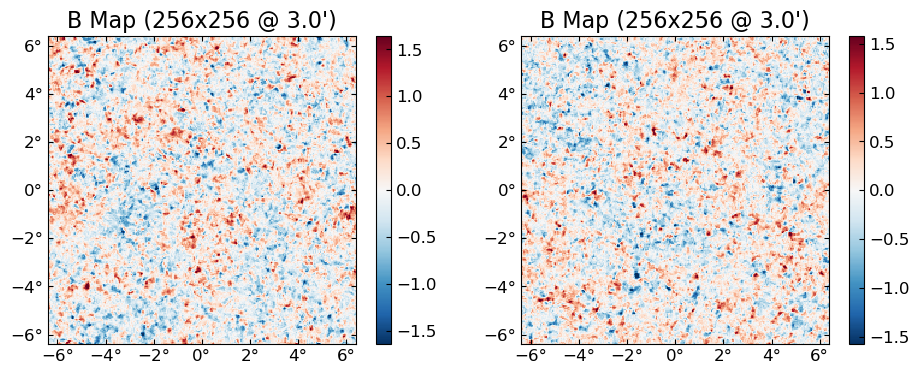

In [73]:
plot([batch_index(f̃_batch,1) batch_index(f̃_batch, 2)], which=:Bx)

`f[!,i]` is short-hand for `batch_index(f,i)`, meant to be used when doing interactive work:

In [74]:
f_batch[!,1] == batch_index(f_batch,1)

true

Normal broadcasting rules apply between batched and non-batched fields, so e.g.:

In [75]:
LenseFlow(ϕ) * f_batch

1310720-element 256×256(×10)-pixel 3.0′-resolution FlatQUMap{CuArray{Float32,4},ProjLambert{Float32}}:
 -1.4941235
 -0.9914128
  1.0198733
  0.88523036
 -0.6625598
 -3.2031393
 -2.0574992
 -1.7696751
 -1.2420458
 -3.2735085
 -4.4636745
 -6.023631
 -6.9492006
  ⋮
  1.3844602
  3.487194
  3.0349822
 -1.9964567
 -3.3094363
  1.3220795
  2.9720027
  0.91866386
 -2.3997512
 -4.35118
 -6.19135
 -6.4957414

works and lenses the 10 different fields in `f_batch` by the _same_ (non-batched) `ϕ`.

Most of CMBLensing works with batched fields just like with normal fields. This includes things like `lnP`, `conjugate_gradient`, `sample_joint`, or `MAP_joint` (although `MAP_marg` only works with non-batched fields, but will be fixed in the future).

## Multiple GPUs

For multi-GPU runs, the easiest way currently is to use one Julia process per GPU. See also the section of the CUDA.jl documentation [here](https://juliagpu.github.io/CUDA.jl/stable/usage/multigpu/). (Note, this is under active developement and it seems likely in the future it will become easier to use multiple GPUs from the same process, saving on memory and startup cost.)

If all your GPUs are on one node, you can use the following code snippet to set up parallel GPUs. Here e.g. we have 4 GPUs, so we launch 4 worker processes:

In [25]:
using Distributed
addprocs(4, exeflags="--project=@.")
@everywhere using CMBLensing
CMBLensing.assign_GPU_workers()

GPU_worker_info:
(master = 1, host = n0299.savio2, device = CuDevice(0): GeForce GTX 1080 Ti 04321c79)
(worker = 2, host = n0299.savio2, device = CuDevice(1): GeForce GTX 1080 Ti eb8fcbf6)
(worker = 3, host = n0299.savio2, device = CuDevice(2): GeForce GTX 1080 Ti 5b58bff4)
(worker = 4, host = n0299.savio2, device = CuDevice(3): GeForce GTX 1080 Ti 0493ddcc)
(worker = 5, host = n0299.savio2, device = CuDevice(0): GeForce GTX 1080 Ti 04321c79)


Now you can use normal Julia parallel constructs to assign work to each GPU. E.g., we can lense each of the batched maps above on separate GPUs: 

In [76]:
batch(pmap(fs, ϕs) do f,ϕ
    LenseFlow(ϕ) * f
end)

1310720-element 256×256(×10)-pixel 3.0′-resolution FlatQUMap{CuArray{Float32,4},ProjLambert{Float32}}:
 -1.4679776
 -2.0485938
  0.23991281
  0.20982413
 -0.42936718
 -2.967942
 -1.9101936
 -1.3053963
 -1.1134857
 -3.3083956
 -4.214875
 -6.73863
 -5.332464
  ⋮
  1.1316952
  1.8423452
  1.8628787
 -2.643449
 -4.822819
 -1.0603839
  3.825707
  1.9785323
 -1.6165124
 -3.4116428
 -3.8029394
 -2.3072338

Note that CPU and GPU fields are completely serializable and can be sent back and forth to worker processes, such as happened above. When a GPU fields is sent, it will be copied to the worker's GPU transparently. However, note that it has to pass through CPU memory, so there is sizeable overhead. E.g., in the example above, its *much* faster to perform the batch lense on 1 GPU rather than split across the 4. Indeed, parallel constructs like this are mainly useful for parallelizing over larger workloads where the overhead is insignificant. 

For multi-GPU multi-node jobs, its recommended to set up Julia workers via [MPIClusterManagers.jl](https://github.com/JuliaParallel/MPIClusterManagers.jl). `CMBLensing.assign_GPU_workers()` works with multi-node jobs as well (and knows to assign GPUs to workers only on the same node).

## Gotchas

Not much, hopefully. If something that works on CPU doesn't work on GPU, please file an Issue.

One thing to keep in mind is that CPU and GPU use different random number generators, so seeds will not correspond. Note however you can force a GPU simulation to use the CPU RNG by passing `rng=MersenneTwister()`.

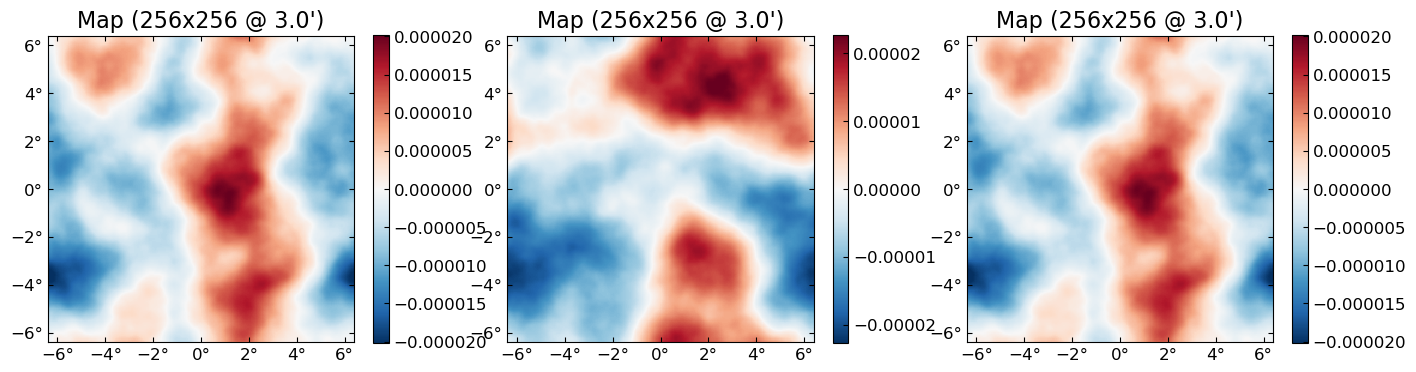

In [50]:
plot(permutedims(cpu.([
    simulate(cpu(ds.Cϕ),seed=0),                         # simulate CPU field
    simulate( cu(ds.Cϕ),seed=0),                         # simulate GPU field
    simulate( cu(ds.Cϕ),seed=0,rng=MersenneTwister())    # simulate GPU field using CPU RNG
])))